# Adagrad

In [2]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np
import time
import tensorflow.examples.tutorials.mnist.input_data as input_data

import sys
tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(2017)

In [4]:
# 数据导入
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)

train_set = mnist.train
test_set = mnist.test

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None, weights_collection='weights', biases_collection='biases'):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        # 注意这里的初始化方法是truncated_normal
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1), shape=(input_depth, output_depth), name='weights')
        
        tf.add_to_collection(weights_collection, w)
        
        # 注意这里用 0.1 对偏置进行初始化
        b = tf.get_variable(initializer=tf.constant_initializer(0.1), shape=(output_depth), name='bias')
        
        tf.add_to_collection(biases_collection, b)
        
        net = tf.matmul(layer_input, w) + b
        
        return net
def DNN(x, output_depths, scope='DNN', reuse=None, weights_collection='weights', biases_collection='biases'):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d' % i, reuse=reuse, weights_collection=weights_collection, biases_collection=biases_collection)
        # 注意这里的激活函数
        net = tf.nn.relu(net)
    # 数字分为0, 1, ..., 9 所以这是10分类问题
    # 对应于 one_hot 的标签, 所以这里输出一个 10维 的向量
    net = hidden_layer(net, 10, scope='classification', reuse=reuse, weights_collection=weights_collection, biases_collection=biases_collection)
    
    return net

# 定义模型
input_ph = tf.placeholder(shape=(None, 784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 10), dtype=tf.int64)

dnn = DNN(input_ph, [200], weights_collection='params', biases_collection='params')

In [6]:
# 构建`loss`和`acc`
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)

acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))

In [7]:
# 获取梯度
params = tf.get_collection('params')

gradients = tf.gradients(loss, params)

### 定义`Adagrad`更新算法

In [8]:
def adagrad_update(params, gradients, sqrs, lr, name='adagrad_update'):
    eps = 1e-10
    
    update_ops = []
    for param, gradient, sqr in zip(params, gradients, sqrs):
        sqr_update = sqr.assign_add(tf.square(gradient))
        with tf.control_dependencies([sqr_update]):
            delta = lr / tf.sqrt(sqr + eps) * gradient
            update_ops.append(param.assign_sub(delta))
            
    update_op = tf.group(*update_ops, name=name)
    return update_op

### 定义辅助变量

In [9]:
with tf.variable_scope('sqrs'):
    for i, param in enumerate(params):
        v = tf.get_variable(param.op.name, shape=param.get_shape(), initializer=tf.zeros_initializer(), dtype=tf.float32)
        tf.add_to_collection('sqrs', v)

In [10]:
sqrs = tf.get_collection('sqrs')

### 使用adagrad定义更新`op`

In [11]:
update_op = adagrad_update(params, gradients, sqrs, 0.01)

In [12]:
sess = tf.InteractiveSession()

### 开始训练

In [13]:
batch_size = 64

sess.run(tf.global_variables_initializer())

train_losses = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses.append(loss_train)
        
    sess.run(update_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.170328
Epoch 2 Train loss: 0.133877
Epoch 3 Train loss: 0.113939
Epoch 4 Train loss: 0.101687
Epoch 5 Train loss: 0.091356
Train Done! Cost Time: 12.00s


结果:

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline

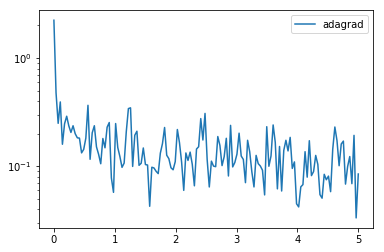

In [15]:
x_axis = np.linspace(0, 5, len(train_losses), endpoint=True)
plt.semilogy(x_axis, train_losses, label='adagrad')
plt.legend(loc='best')

### tf.train.AdagradOptimizer

In [16]:
train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)

In [17]:
sess.run(tf.global_variables_initializer())

train_losses1 = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses1.append(loss_train)
        
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.358515
Epoch 2 Train loss: 0.290524
Epoch 3 Train loss: 0.255720
Epoch 4 Train loss: 0.230657
Epoch 5 Train loss: 0.211861
Train Done! Cost Time: 12.71s
